Auxiliary GAN is similar to conditional GAN. The difference is that in ACGAN, the discriminator does not receive input of class labels. Instead it makes predictions of class labels of image and also weather an image is real or fake without receiving the labels as input. The generator in ACGAN is provided with both the labels and latent space points.

The generator is trying to maximise the log-likelihood of prediction of discriminator of the correct class (LC) and minimise the log-likelihood in ability of discriminator in detecting real and fake images (LS). The discriminator is trying to maximise both LS and LC. 

Discriminator : LS + LC

Generator     : LC - LS

This causes AC-GANs learn a representation for latent space that is independent of class label. This results in higher quality samples and more stable training.

In [1]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim = 110, img_channels = 1, hidden_dim = 64):
        super(Generator, self).__init__()
        
        self.z_dim = z_dim
        self.emb = nn.Embedding(10, 10)
        
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim*16, 4, 1, 0),
            self.gen_block(hidden_dim*16, hidden_dim*8, 4, 2, 1),
            self.gen_block(hidden_dim*8, hidden_dim*4, 4, 2, 1),
            self.gen_block(hidden_dim*4, hidden_dim*2, 4, 2, 1),
            nn.ConvTranspose2d(hidden_dim*2, 1, kernel_size = 4, stride = 2, padding = 1),
            nn.Tanh()
        )
        
    def gen_block(self, input_channels, output_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU()
        )
    
    def forward(self, noise, labels):
        embedding = self.emb(labels)
        embedding_noise = torch.cat((noise, embedding), 1)
        embedding_noise = embedding_noise.view(-1, self.z_dim, 1, 1)
        img = self.gen(embedding_noise)
        return img.view(img.size(0), 1, 64, 64)

In [3]:
def test():
    x = torch.randn((64, 100))
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, 64)))
    gen = Generator()
    preds = gen(x, fake_labels)
    print(preds.shape)
    
test()

torch.Size([64, 1, 64, 64])


In [4]:
def get_noise(n_samples, z_dim):
    return torch.randn(n_samples, z_dim).to('cuda')

In [5]:
class Discriminator(nn.Module):
    def __init__(self, img_channel = 1, hidden_dim = 64):
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            nn.Conv2d(img_channel, hidden_dim, kernel_size = 4, stride = 2, padding = 1),
            nn.LeakyReLU(0.2),
            self.disc_block(hidden_dim, hidden_dim*2, 4, 2, 1),
            self.disc_block(hidden_dim*2, hidden_dim*4, 4, 2, 1),
            self.disc_block(hidden_dim*4, hidden_dim*8, 4, 2, 1),
#             nn.Conv2d(hidden_dim*8, 1, kernel_size = 4, stride = 2, padding = 0),    
        )
        
        self.label = nn.Sequential(
            nn.Conv2d(hidden_dim*8, 1, kernel_size = 4, stride = 2, padding = 0),    
            nn.Sigmoid()
        )
        
        self.classifier = nn.Sequential(
            nn.Conv2d(hidden_dim*8, 10, kernel_size = 4, stride = 2, padding = 0),    
            nn.LogSoftmax(dim = 1)
        )
        
        
    def disc_block(self, input_channels, output_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, img):
        disc_maps = self.disc(img)
        label = self.label(disc_maps)
        classes = self.classifier(disc_maps)
        return label, classes
        

In [6]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02),
        torch.nn.init.normal_(m.bias, 0)

In [7]:
n_epochs = 100
z_dim = 100
batch_size = 64
beta_1 = 0.5
beta_2 = 0.999
lr = 0.0001
image_size = 64
device = 'cuda'
criterion = nn.BCELoss()
criterion2 = nn.NLLLoss()

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

dataloader = DataLoader(
    FashionMNIST(".", download = False, transform = transform),
    batch_size = batch_size,
    shuffle = True
)

In [8]:
gen = Generator().to(device)
disc = Discriminator().to(device)

weights_init(gen)
weights_init(disc)

opt_gen = torch.optim.Adam(gen.parameters(), lr = lr, betas = (beta_1, beta_2))
opt_disc = torch.optim.Adam(disc.parameters(), lr = lr, betas = (beta_1, beta_2))

In [9]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    img = img.detach().cpu()
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Epochs: 0 Step: 500 Generator loss: 2.5773139449208973, discriminator loss: 0.24185158514231445


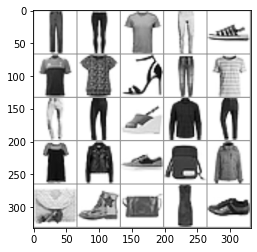

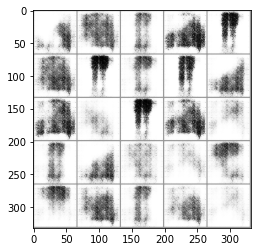

Epochs: 1 Step: 1000 Generator loss: 1.1399002754688263, discriminator loss: 0.32488509291410445


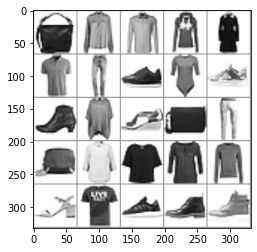

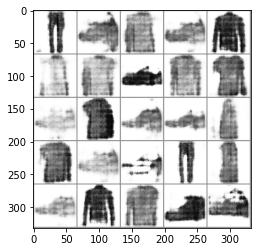

Epochs: 1 Step: 1500 Generator loss: 1.1268928219079972, discriminator loss: 0.31715395960211756


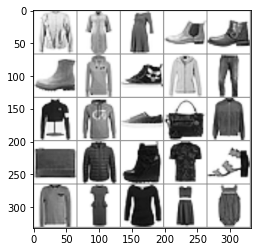

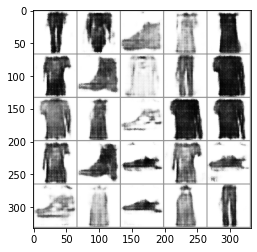

Epochs: 2 Step: 2000 Generator loss: 1.279286114215851, discriminator loss: 0.28430254861712456


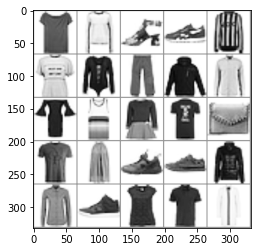

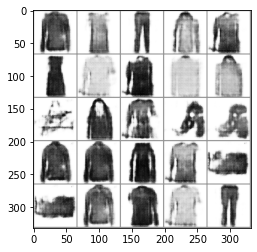

Epochs: 2 Step: 2500 Generator loss: 1.3083574907183648, discriminator loss: 0.2642928039729595


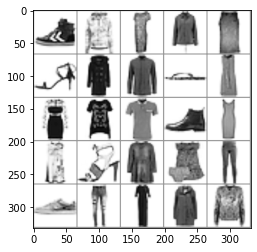

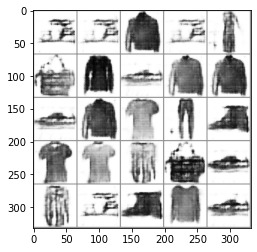

Epochs: 3 Step: 3000 Generator loss: 1.4072746863365173, discriminator loss: 0.23990725687146186


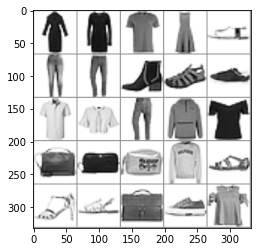

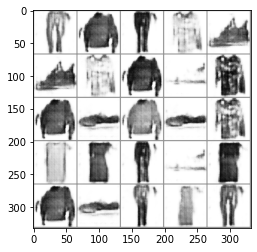

Epochs: 3 Step: 3500 Generator loss: 1.4716121825575827, discriminator loss: 0.21336426091194152


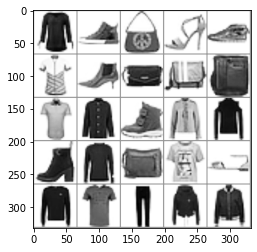

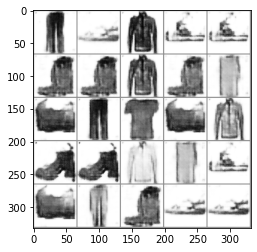

Epochs: 4 Step: 4000 Generator loss: 1.5813840141296387, discriminator loss: 0.20056093633174896


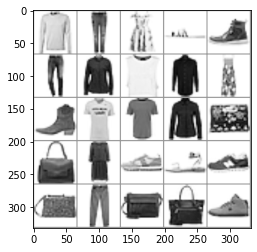

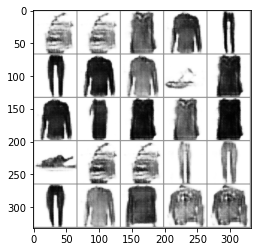

Epochs: 4 Step: 4500 Generator loss: 1.6465100858211517, discriminator loss: 0.18905197371542454


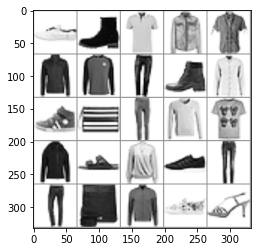

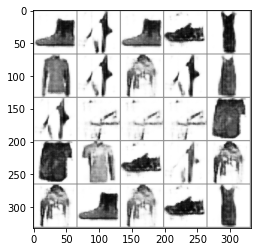

Epochs: 5 Step: 5000 Generator loss: 1.7482505266666413, discriminator loss: 0.1876247139275074


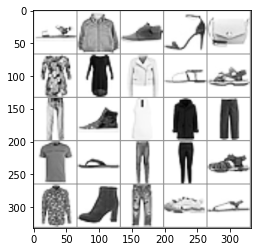

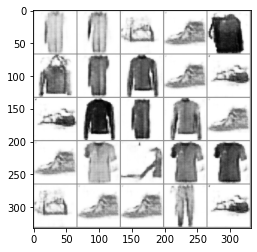

Epochs: 5 Step: 5500 Generator loss: 1.7769806618094444, discriminator loss: 0.1805385399311781


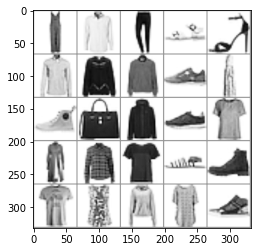

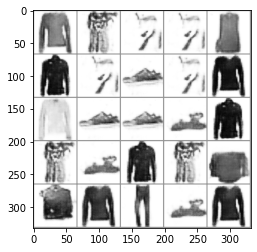

KeyboardInterrupt: 

In [10]:
current_step = 0
gen_losses = 0
disc_losses = 0
steps = 500
os.makedirs('ACGAN', exist_ok = True)

for epoch in range(n_epochs):
    for real, labels in(dataloader):
        real_imgs = Variable(real.type(torch.FloatTensor)).to(device)
        labels = Variable(labels.type(torch.LongTensor)).to(device)
        
        opt_disc.zero_grad()
        fake_noise = get_noise(len(real), z_dim)
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, len(real)))).to(device)
        fake = gen(fake_noise, fake_labels)
        fake_preds_labels, fake_preds_classes = disc(fake.detach())
        fake_preds_labels = fake_preds_labels.view(-1)
        fake_preds_classes = fake_preds_classes.view(-1, 10)
        disc_fakelabel_loss = criterion(fake_preds_labels, torch.zeros_like(fake_preds_labels))
        disc_fakeclass_loss = criterion2(fake_preds_classes, fake_labels)
        disc_fake_loss = (disc_fakelabel_loss + disc_fakeclass_loss) / 2
        
        real_preds_labels, real_preds_classes = disc(real_imgs)
        real_preds_labels = real_preds_labels.view(-1)
        real_preds_classes = real_preds_classes.view(-1, 10)
        disc_reallabel_loss = criterion(real_preds_labels, torch.ones_like(real_preds_labels))
        disc_realclass_loss = criterion2(real_preds_classes, labels)
        disc_real_loss = (disc_reallabel_loss + disc_realclass_loss) / 2
        
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward()
        opt_disc.step()
        disc_losses += disc_loss.item()


        opt_gen.zero_grad()
        fake_noise_2 = get_noise(len(real), z_dim)
        fake_labels_2  = Variable(torch.LongTensor(np.random.randint(0, 10, len(real)))).to(device)
        fake_2 = gen(fake_noise_2, fake_labels_2)
        fake_preds_labels, fake_preds_classes = disc(fake_2)
        fake_preds_labels = fake_preds_labels.view(-1)
        fake_preds_classes = fake_preds_classes.view(-1, 10)
        disc_fakelabel_loss = criterion(fake_preds_labels, torch.ones_like(fake_preds_labels))
        disc_fakeclass_loss = criterion2(fake_preds_classes, fake_labels_2)
        gen_loss = (disc_fakelabel_loss + disc_fakeclass_loss) / 2
        gen_loss.backward()
        opt_gen.step()
        gen_losses += gen_loss.item()
        
        if current_step % steps == 0 and current_step > 0:
            print(f"Epochs: {epoch} Step: {current_step} Generator loss: {gen_losses / steps}, discriminator loss: {disc_losses / steps}")
            img_grid_real = torchvision.utils.make_grid(real[:25], nrow = 5)
            img_grid_fake = torchvision.utils.make_grid(fake[:25], nrow = 5)
            save_image(fake_2.data[:36], 'ACGAN/%d.png' % current_step, nrow = 6, normalize = True)
            matplotlib_imshow(img_grid_real, one_channel = True)
            matplotlib_imshow(img_grid_fake, one_channel = True)
            gen_losses = 0
            disc_losses = 0
        
        current_step += 1
        